In [1]:
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.util import get_universal_calculator
from datetime import datetime

from pymatgen.ext.matproj import MPRester

In [2]:
mpr = MPRester()

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


In [3]:
mpdata = mpr.materials._search(nelements=2, fields=["material_id", "structure"])

Retrieving MaterialsDoc documents:   0%|          | 0/20627 [00:00<?, ?it/s]

In [4]:
calc = get_universal_calculator("M3GNet")

/Users/shyue/repos/matgl/matgl/utils/io.py:125: UserWarning: Incompatible model version detected! The code will continue to load the model but it is recommended that you provide a path to an updated model, increment your @model_version in model.json if you are confident that the changes are not problematic, or clear your ~/.matgl cache using `python -c "import matgl; matgl.clear_cache()"`
  _check_ver(cls_, v)  # Check version of any subclasses too.


In [5]:
fmax = 0.01
calculators = [
    ("relax", RelaxCalc(calc, fmax=fmax)), 
    ("elastic", ElasticityCalc(calc, fmax=fmax, relax_structure=False)), 
    ("eos", EOSCalc(calc, fmax=fmax, relax_structure=False)),
    # Note that Phonon usually requires a more stringent fmax criterion and a re-relaxation.
    ("phonon", PhononCalc(calc, relax_structure=False, fmax=fmax)), 
]

In [6]:
data = []

for i, d in enumerate(mpdata):
    s = d.structure
    dd = {"mid": d.material_id, "composition": s.composition.formula, "nsites": len(s)}
    properties = {}
    for name, c in calculators:
        starttime = datetime.now()
        properties[name] = c.calc(s)
        endtime = datetime.now()
        if name == "relax":
            s = properties[name]["final_structure"]
        dd[f"time_{name}"] = (endtime - starttime).total_seconds()
    dd["properties"] = properties
    data.append(dd)
    if i == 20:
        # Here we just do a sampling of 10 structures.
        break

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
import pandas as pd
df = pd.DataFrame(data)

In [8]:
df

,mid,composition,nsites,time_relax,time_elastic,time_eos,time_phonon,properties
0,mp-1106268,Pr14 Pd6,20,82.252866,0.418490,16.531636,21.289642,{'relax': {'final_structure': [[-5.19299035 2...
1,mp-974315,Ru2 I2,4,1.354971,0.199866,4.355355,0.815008,{'relax': {'final_structure': [[ 1.83881118 -1...
2,mp-1206714,Al2 Sn1,3,0.446675,0.124788,0.239677,0.247754,{'relax': {'final_structure': [[1.59917846 1.5...
3,mp-30339,Er1 Ag2,3,0.713667,0.192773,2.637257,0.448705,{'relax': {'final_structure': [[4.48158802e-07...
4,mp-696,Si4 Pt4,8,17.972885,0.343178,20.778588,7.406129,{'relax': {'final_structure': [[0.88083747 3.9...
5,mp-866222,Ac2 Si6,8,21.819111,0.252701,3.868791,1.702701,{'relax': {'final_structure': [[-2.05389424e-0...
6,mp-11422,Gd1 Hg1,2,0.255837,0.109605,0.172415,0.147920,{'relax': {'final_structure': [[5.55001412e-20...
7,mp-21238,Th4 Si4,8,5.042617,0.248163,7.904498,0.785278,{'relax': {'final_structure': [[1.08998567 0.7...
8,mp-1215363,Zr4 Pd1,5,1.437936,0.176616,6.527801,1.083309,{'relax': {'final_structure': [[ 3.93732368e-0...
9,mp-1212658,Ga1 C6,7,2.139265,0.203957,3.475310,1.177860,{'relax': {'final_structure': [[-9.88259495e-0...


<Axes: xlabel='nsites', ylabel='time_relax'>

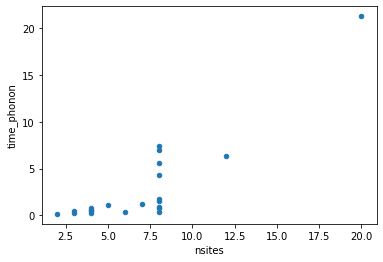

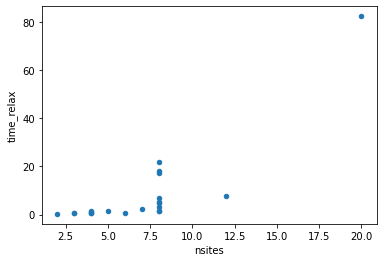

In [9]:
df.plot(x="nsites", y="time_phonon", kind="scatter")
df.plot(x="nsites", y="time_relax", kind="scatter")